In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tools import add_constant
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
OUT = Path("../output")
EVENT_DIR = OUT / "event_study_outputs"

shock_df = pd.read_csv(OUT / "shock_beta_summary.csv", parse_dates=['shock_date'])
sigma_df = pd.read_csv(EVENT_DIR / "sigma_convergence_event_path.csv")  
beta_df  = pd.read_csv(EVENT_DIR / "beta_convergence_event_path.csv")

print("Shock summary and event-study outputs loaded.")
print("Columns in sigma_df:", sigma_df.columns.tolist())
display(shock_df.head())
display(sigma_df.head())
display(beta_df.head())

window_list = [1, 2, 6]
mult_list   = [0.5, 1.0, 1.5]
summaries   = []

for w, m in itertools.product(window_list, mult_list):
    # detect shocks with multiplier m
    sigma_series = (
        sigma_df.groupby('event_time')[['avg_sigma','w_sigma']]
        .std().dropna().reset_index()
    )
    # use unweighted for threshold, but we can also test weighted
    thr = sigma_series['avg_sigma'].mean() + m*sigma_series['avg_sigma'].std()
    chosen = sigma_series[sigma_series['avg_sigma'] > thr]
    if chosen.empty:
        chosen = sigma_series.sort_values('avg_sigma', ascending=False).head(12)
    sdates = pd.to_datetime(chosen['event_time']).sort_values().tolist()

    rows = []
    for sdate in sdates:
        win = sigma_df[sigma_df['event_time'] == sdate]
        beta_val = beta_df.loc[beta_df['event_time']==sdate, 'beta'].values
        if len(beta_val) > 0:
            rows.append(beta_val[0])

    if len(rows) > 0:
        summaries.append({
            'window_months': w,
            'multiplier': m,
            'n_shocks_used': len(rows),
            'mean_beta': np.nanmean(rows),
            'median_beta': np.nanmedian(rows),
            'std_beta': np.nanstd(rows)
        })
    else:
        summaries.append({
            'window_months': w,
            'multiplier': m,
            'n_shocks_used': 0,
            'mean_beta': np.nan,
            'median_beta': np.nan,
            'std_beta': np.nan
        })

robust_df = pd.DataFrame(summaries)
robust_df.to_csv(OUT / "robustness_grid_summary.csv", index=False)
print("Robustness grid saved:", OUT / "robustness_grid_summary.csv")
display(robust_df)


Shock summary and event-study outputs loaded.
Columns in sigma_df: ['event_time', 'avg_sigma', 'shock_date', 'w_sigma']


,shock_date,n_obs,beta,se,half_life_months
0,2020-06-01,396,-0.022012,0.012902,31.141117
1,2020-07-01,396,-0.023481,0.012808,29.170920
2,2020-11-01,396,-0.016139,0.009910,42.602115
3,2020-12-01,396,-0.022634,0.008824,30.276382
4,2021-01-01,396,-0.020905,0.008830,32.809389


,event_time,avg_sigma,shock_date,w_sigma
0,-6,0.044594,2024-05-01,0.043914
1,-5,0.046106,2024-05-01,0.045402
2,-4,0.045833,2024-05-01,0.045133
3,-3,0.045795,2024-05-01,0.045096
4,-2,0.045684,2024-05-01,0.044987


,event_time,beta,se,half_life_months,n
0,-5,-0.028376,0.009159,24.079262,231
1,-4,-0.015741,0.009339,43.687682,231
2,-3,-0.027746,0.012426,24.633786,231
3,-2,0.007823,0.016471,NaN,231
4,-1,-0.010969,0.021093,62.844251,231


Robustness grid saved: ..\output\robustness_grid_summary.csv


,window_months,multiplier,n_shocks_used,mean_beta,median_beta,std_beta
0,1,0.5,0,NaN,NaN,NaN
1,1,1.0,0,NaN,NaN,NaN
2,1,1.5,0,NaN,NaN,NaN
3,2,0.5,0,NaN,NaN,NaN
4,2,1.0,0,NaN,NaN,NaN
5,2,1.5,0,NaN,NaN,NaN
6,6,0.5,0,NaN,NaN,NaN
7,6,1.0,0,NaN,NaN,NaN
8,6,1.5,0,NaN,NaN,NaN


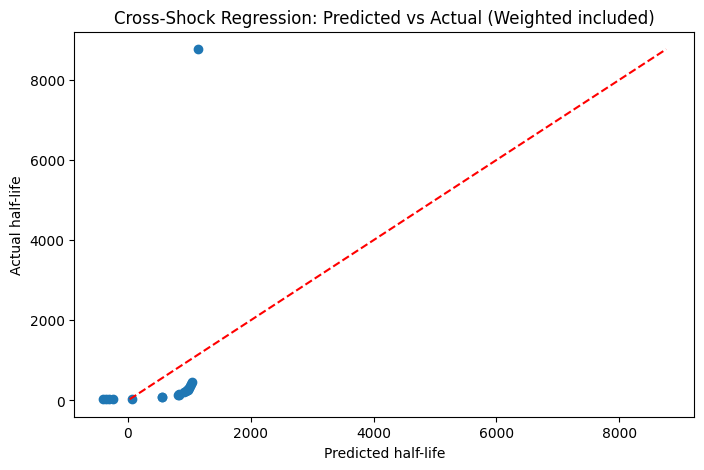

In [3]:
WINDOW_MONTHS = 6

shock_df = pd.read_csv("../output/shock_beta_summary.csv", parse_dates=['shock_date'])
sigma_df = pd.read_csv("../output/event_study_outputs/sigma_convergence_event_path.csv")

avg_sigma_list = []
w_sigma_list   = []

for _, row in shock_df.iterrows():
    temp = sigma_df[(sigma_df['event_time'] >= -WINDOW_MONTHS) &
                    (sigma_df['event_time'] <= WINDOW_MONTHS)]
    avg_sigma_list.append(temp['avg_sigma'].mean())
    if 'w_sigma' in temp.columns:
        w_sigma_list.append(temp['w_sigma'].mean())
    else:
        w_sigma_list.append(np.nan)

cross_df = shock_df.copy()
cross_df['avg_sigma'] = avg_sigma_list
cross_df['w_sigma']   = w_sigma_list   

# Regression still on unweighted as baseline
X = cross_df[['beta', 'avg_sigma', 'w_sigma']]  # we can test both
y = cross_df['half_life_months']

mask = X.notna().all(axis=1) & y.notna()
X_clean = X[mask]
y_clean = y[mask]

model = sm.OLS(y_clean, X_clean).fit(cov_type='HC1')

# Plot predicted vs actual
plt.figure(figsize=(8,5))
plt.scatter(model.fittedvalues, y_clean)
plt.plot([y_clean.min(), y_clean.max()], [y_clean.min(), y_clean.max()], 'r--')
plt.xlabel("Predicted half-life")
plt.ylabel("Actual half-life")
plt.title("Cross-Shock Regression: Predicted vs Actual (Weighted included)")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.67      1.00      0.80         4

    accuracy                           0.75         8
   macro avg       0.83      0.75      0.73         8
weighted avg       0.83      0.75      0.73         8



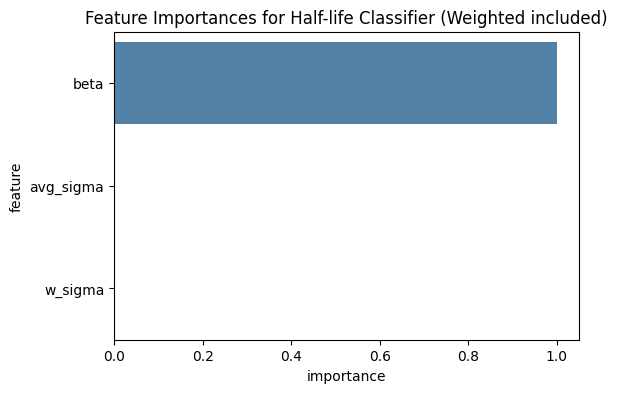

In [4]:
median_hl = y.median()
cross_df['hl_class'] = (cross_df['half_life_months'] > median_hl).astype(int)

ml_df = cross_df.dropna(subset=['beta','avg_sigma','w_sigma','hl_class'])
X_ml = ml_df[['beta','avg_sigma','w_sigma']]  
y_ml = ml_df['hl_class']

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

feat_imp = pd.DataFrame({
    'feature': X_ml.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=feat_imp, x='importance', y='feature', color='steelblue')
plt.title("Feature Importances for Half-life Classifier (Weighted included)")
plt.show()